In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, AutoTokenizer
import torch
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support, confusion_matrix
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px
from sklearn.preprocessing import StandardScaler
import kagglehub
from datasets import Dataset, DatasetDict
import json
#from excel2json import convert_from_file
import seaborn as sns

/home/iza/Desktop/Studia/sem2/nlp/NLP_task1/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [3]:
path = kagglehub.dataset_download("waalbannyantudre/hate-speech-detection-curated-dataset")

print("Path to dataset files:", path)

Path to dataset files: /home/iza/.cache/kagglehub/datasets/waalbannyantudre/hate-speech-detection-curated-dataset/versions/1


In [4]:
import os

files = os.listdir(path)
print(files)


['HateSpeechDatasetBalanced.csv', 'HateSpeechDataset.csv']


In [5]:
# Wczytywanie danych

# Specify the path to the CSV file
csv_file_path = os.path.join(path, 'HateSpeechDataset.csv') 

df = pd.read_csv(csv_file_path)
df['text'] = df['Content']
df = df.drop(columns=['Content_int', 'Content'])
df = df[df['Label'] != 'Label']



In [6]:
# Podział danych
texts_train, texts_test, text_labels_train, text_labels_test = train_test_split(
    df['text'], df['Label'], test_size=0.2, random_state=42
)

df_train = pd.DataFrame({'text': texts_train, 'LABEL': text_labels_train})
df_test = pd.DataFrame({'text': texts_test, 'LABEL': text_labels_test})

In [7]:
# Ustalanie minimalnej liczby klas
min_class_count_train = 1000
min_class_count_test = 500

df_train_balanced = df_train.groupby('LABEL').apply(lambda x: x.sample(min_class_count_train)).reset_index(drop=True)
df_test_balanced = df_test.groupby('LABEL').apply(lambda x: x.sample(min_class_count_test)).reset_index(drop=True)

train_json = df_train_balanced.to_json(orient='records')
test_json = df_test_balanced.to_json(orient='records')

train_dataset = Dataset.from_list(json.loads(train_json))
test_dataset = Dataset.from_list(json.loads(test_json))

dataset = DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})



/tmp/ipykernel_5597/2564637914.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train_balanced = df_train.groupby('LABEL').apply(lambda x: x.sample(min_class_count_train)).reset_index(drop=True)
/tmp/ipykernel_5597/2564637914.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_test_balanced = df_test.groupby('LABEL').apply(lambda x: x.sample(min_class_count_test)).reset_index(drop=True)


In [8]:
# Mapowanie etykiet
sorted_labels = sorted(set(dataset['train']['LABEL']))
label2id = dict(zip(sorted_labels, range(len(sorted_labels))))
id2label = dict(zip(range(len(sorted_labels)), sorted_labels))

In [9]:
# Tokenizacja
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # Set pad_token to be the same as eos_token
model = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels=len(label2id), label2id=label2id, id2label=id2label)


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# Funkcja preprocessing
def preprocess_function(examples):
    tokens = tokenizer(examples["text"], padding="max_length", truncation=True, return_tensors='pt')
    tokens['label'] = [label2id[l] for l in examples["LABEL"]]
    return tokens


In [11]:
# Tokenizacja zbiorów
tokenized_ds = {}
for split in ['train', 'test']:
    tokenized_ds[split] = dataset[split].map(preprocess_function, batched=True)



Map: 100%|██████████| 1000/1000 [00:00<00:00, 2313.69 examples/s]


In [12]:
# Funkcja do obliczania metryk
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": (predictions == labels).mean() * 100, "f1": f1_score(labels, predictions, average='weighted')}


In [13]:
import torch

torch.cuda.empty_cache()


In [14]:
trainer = Trainer(
    model=model,
    args=TrainingArguments(
        output_dir="gpt2-classification",
        learning_rate=2e-5,
        per_device_train_batch_size=1,
        per_device_eval_batch_size=1,
        num_train_epochs=10,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
    ),
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"],
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)

trainer.train()


/home/iza/Desktop/Studia/sem2/nlp/NLP_task1/.venv/lib/python3.10/site-packages/transformers/training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_5597/3097965231.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
  2%|▎         | 500/20000 [02:06<1:21:11,  4.00it/s]

{'loss': 1.8187, 'grad_norm': 525.7158203125, 'learning_rate': 1.95e-05, 'epoch': 0.25}


  5%|▌         | 1000/20000 [04:12<1:22:55,  3.82it/s]

{'loss': 1.581, 'grad_norm': 0.022512713447213173, 'learning_rate': 1.9e-05, 'epoch': 0.5}


  8%|▊         | 1500/20000 [06:20<1:20:22,  3.84it/s]

{'loss': 1.2469, 'grad_norm': 0.0278032049536705, 'learning_rate': 1.8500000000000002e-05, 'epoch': 0.75}


 10%|█         | 2000/20000 [08:27<1:15:05,  4.00it/s]

{'loss': 1.3649, 'grad_norm': 0.33925604820251465, 'learning_rate': 1.8e-05, 'epoch': 1.0}


                                                      
 10%|█         | 2000/20000 [09:34<1:15:05,  4.00it/s]

{'eval_loss': 1.6065170764923096, 'eval_accuracy': 77.8, 'eval_f1': 0.7736901553178736, 'eval_runtime': 67.0738, 'eval_samples_per_second': 14.909, 'eval_steps_per_second': 14.909, 'epoch': 1.0}


 12%|█▎        | 2500/20000 [11:42<1:16:14,  3.83it/s]  

{'loss': 1.0379, 'grad_norm': 0.0022279226686805487, 'learning_rate': 1.7500000000000002e-05, 'epoch': 1.25}


 15%|█▌        | 3000/20000 [13:50<1:11:30,  3.96it/s]

{'loss': 1.1095, 'grad_norm': 0.015568990260362625, 'learning_rate': 1.7e-05, 'epoch': 1.5}


 18%|█▊        | 3500/20000 [15:58<1:09:04,  3.98it/s]

{'loss': 1.0333, 'grad_norm': 129.01864624023438, 'learning_rate': 1.65e-05, 'epoch': 1.75}


 20%|██        | 4000/20000 [18:05<1:06:55,  3.98it/s]

{'loss': 1.0176, 'grad_norm': 256.08306884765625, 'learning_rate': 1.6000000000000003e-05, 'epoch': 2.0}


                                                      
 20%|██        | 4000/20000 [19:12<1:06:55,  3.98it/s]

{'eval_loss': 1.2906991243362427, 'eval_accuracy': 79.0, 'eval_f1': 0.786502049580324, 'eval_runtime': 66.8347, 'eval_samples_per_second': 14.962, 'eval_steps_per_second': 14.962, 'epoch': 2.0}


 22%|██▎       | 4500/20000 [21:18<1:04:46,  3.99it/s] 

{'loss': 0.5664, 'grad_norm': 0.0014036179054528475, 'learning_rate': 1.55e-05, 'epoch': 2.25}


 25%|██▌       | 5000/20000 [23:24<1:02:37,  3.99it/s]

{'loss': 0.7509, 'grad_norm': 267.0464782714844, 'learning_rate': 1.5000000000000002e-05, 'epoch': 2.5}


 28%|██▊       | 5500/20000 [25:29<1:00:28,  4.00it/s]

{'loss': 0.6574, 'grad_norm': 0.9827527403831482, 'learning_rate': 1.45e-05, 'epoch': 2.75}


 30%|███       | 6000/20000 [27:34<58:20,  4.00it/s]  

{'loss': 0.8215, 'grad_norm': 0.05611497536301613, 'learning_rate': 1.4e-05, 'epoch': 3.0}


                                                    
 30%|███       | 6000/20000 [28:41<58:20,  4.00it/s]

{'eval_loss': 1.5207279920578003, 'eval_accuracy': 77.3, 'eval_f1': 0.7728998488333354, 'eval_runtime': 66.7394, 'eval_samples_per_second': 14.984, 'eval_steps_per_second': 14.984, 'epoch': 3.0}


 32%|███▎      | 6500/20000 [30:48<56:11,  4.00it/s]   

{'loss': 0.482, 'grad_norm': 0.03133274242281914, 'learning_rate': 1.3500000000000001e-05, 'epoch': 3.25}


 35%|███▌      | 7000/20000 [32:53<54:07,  4.00it/s]

{'loss': 0.6323, 'grad_norm': 0.0006074735429137945, 'learning_rate': 1.3000000000000001e-05, 'epoch': 3.5}


 38%|███▊      | 7500/20000 [34:58<52:03,  4.00it/s]

{'loss': 0.4676, 'grad_norm': 0.018780037760734558, 'learning_rate': 1.25e-05, 'epoch': 3.75}


 40%|████      | 8000/20000 [37:03<49:54,  4.01it/s]

{'loss': 0.4299, 'grad_norm': 0.004145062528550625, 'learning_rate': 1.2e-05, 'epoch': 4.0}


                                                    
 40%|████      | 8000/20000 [38:10<49:54,  4.01it/s]

{'eval_loss': 1.4898967742919922, 'eval_accuracy': 79.10000000000001, 'eval_f1': 0.7907989577984442, 'eval_runtime': 66.7054, 'eval_samples_per_second': 14.991, 'eval_steps_per_second': 14.991, 'epoch': 4.0}


 42%|████▎     | 8500/20000 [40:16<47:56,  4.00it/s]   

{'loss': 0.314, 'grad_norm': 0.0062177530489861965, 'learning_rate': 1.15e-05, 'epoch': 4.25}


 45%|████▌     | 9000/20000 [42:21<45:53,  3.99it/s]

{'loss': 0.3168, 'grad_norm': 0.0029862201772630215, 'learning_rate': 1.1000000000000001e-05, 'epoch': 4.5}


 48%|████▊     | 9500/20000 [44:26<43:42,  4.00it/s]

{'loss': 0.4015, 'grad_norm': 0.0005514986114576459, 'learning_rate': 1.0500000000000001e-05, 'epoch': 4.75}


 50%|█████     | 10000/20000 [46:31<41:46,  3.99it/s]

{'loss': 0.3058, 'grad_norm': 0.0007403414929285645, 'learning_rate': 1e-05, 'epoch': 5.0}


                                                     
 50%|█████     | 10000/20000 [47:38<41:46,  3.99it/s]

{'eval_loss': 1.6884185075759888, 'eval_accuracy': 79.80000000000001, 'eval_f1': 0.7979709078107249, 'eval_runtime': 66.6553, 'eval_samples_per_second': 15.003, 'eval_steps_per_second': 15.003, 'epoch': 5.0}


 52%|█████▎    | 10500/20000 [49:44<39:37,  4.00it/s]   

{'loss': 0.1951, 'grad_norm': 0.0010085797403007746, 'learning_rate': 9.5e-06, 'epoch': 5.25}


 55%|█████▌    | 11000/20000 [51:49<37:32,  4.00it/s]

{'loss': 0.2309, 'grad_norm': 0.0016024637734517455, 'learning_rate': 9e-06, 'epoch': 5.5}


 57%|█████▊    | 11500/20000 [53:54<35:20,  4.01it/s]

{'loss': 0.2172, 'grad_norm': 0.00012065844202879816, 'learning_rate': 8.5e-06, 'epoch': 5.75}


 60%|██████    | 12000/20000 [55:59<33:06,  4.03it/s]

{'loss': 0.1326, 'grad_norm': 0.015008958987891674, 'learning_rate': 8.000000000000001e-06, 'epoch': 6.0}


                                                     
 60%|██████    | 12000/20000 [57:06<33:06,  4.03it/s]

{'eval_loss': 1.6763312816619873, 'eval_accuracy': 81.0, 'eval_f1': 0.8096955128205128, 'eval_runtime': 66.6636, 'eval_samples_per_second': 15.001, 'eval_steps_per_second': 15.001, 'epoch': 6.0}


 62%|██████▎   | 12500/20000 [59:11<31:07,  4.02it/s]   

{'loss': 0.1313, 'grad_norm': 0.08698493242263794, 'learning_rate': 7.500000000000001e-06, 'epoch': 6.25}


 65%|██████▌   | 13000/20000 [1:01:16<28:56,  4.03it/s]

{'loss': 0.0745, 'grad_norm': 0.008244886994361877, 'learning_rate': 7e-06, 'epoch': 6.5}


 68%|██████▊   | 13500/20000 [1:03:20<26:54,  4.03it/s]

{'loss': 0.2182, 'grad_norm': 0.006949257105588913, 'learning_rate': 6.5000000000000004e-06, 'epoch': 6.75}


 70%|███████   | 14000/20000 [1:05:25<24:43,  4.05it/s]

{'loss': 0.069, 'grad_norm': 5.631286512652878e-07, 'learning_rate': 6e-06, 'epoch': 7.0}


                                                       
 70%|███████   | 14000/20000 [1:06:31<24:43,  4.05it/s]

{'eval_loss': 2.0751218795776367, 'eval_accuracy': 80.7, 'eval_f1': 0.8066083819734963, 'eval_runtime': 66.7786, 'eval_samples_per_second': 14.975, 'eval_steps_per_second': 14.975, 'epoch': 7.0}


 72%|███████▎  | 14500/20000 [1:08:37<22:44,  4.03it/s]   

{'loss': 0.0431, 'grad_norm': 0.00010002268390962854, 'learning_rate': 5.500000000000001e-06, 'epoch': 7.25}


 75%|███████▌  | 15000/20000 [1:10:41<20:41,  4.03it/s]

{'loss': 0.0487, 'grad_norm': 5.826273263664916e-05, 'learning_rate': 5e-06, 'epoch': 7.5}


 78%|███████▊  | 15500/20000 [1:12:45<18:34,  4.04it/s]

{'loss': 0.1009, 'grad_norm': 0.010692217387259007, 'learning_rate': 4.5e-06, 'epoch': 7.75}


 80%|████████  | 16000/20000 [1:14:49<16:32,  4.03it/s]

{'loss': 0.0833, 'grad_norm': 4.6871414269844536e-06, 'learning_rate': 4.000000000000001e-06, 'epoch': 8.0}


                                                       
 80%|████████  | 16000/20000 [1:15:56<16:32,  4.03it/s]

{'eval_loss': 2.205946683883667, 'eval_accuracy': 80.2, 'eval_f1': 0.8016501107954432, 'eval_runtime': 67.2058, 'eval_samples_per_second': 14.88, 'eval_steps_per_second': 14.88, 'epoch': 8.0}


 82%|████████▎ | 16500/20000 [1:18:04<14:33,  4.01it/s]   

{'loss': 0.0598, 'grad_norm': 5.627433893096168e-06, 'learning_rate': 3.5e-06, 'epoch': 8.25}


 85%|████████▌ | 17000/20000 [1:20:10<12:37,  3.96it/s]

{'loss': 0.016, 'grad_norm': 0.21271416544914246, 'learning_rate': 3e-06, 'epoch': 8.5}


 88%|████████▊ | 17500/20000 [1:22:21<10:52,  3.83it/s]

{'loss': 0.0301, 'grad_norm': 0.0003754711651708931, 'learning_rate': 2.5e-06, 'epoch': 8.75}


 90%|█████████ | 18000/20000 [1:24:30<08:27,  3.94it/s]

{'loss': 0.0024, 'grad_norm': 3.751406984520145e-05, 'learning_rate': 2.0000000000000003e-06, 'epoch': 9.0}


                                                       
 90%|█████████ | 18000/20000 [1:25:39<08:27,  3.94it/s]

{'eval_loss': 2.4771385192871094, 'eval_accuracy': 79.60000000000001, 'eval_f1': 0.7959600081615997, 'eval_runtime': 69.1832, 'eval_samples_per_second': 14.454, 'eval_steps_per_second': 14.454, 'epoch': 9.0}


 92%|█████████▎| 18500/20000 [1:27:49<06:29,  3.85it/s]   

{'loss': 0.0202, 'grad_norm': 0.00012629316188395023, 'learning_rate': 1.5e-06, 'epoch': 9.25}


 95%|█████████▌| 19000/20000 [1:29:58<04:12,  3.96it/s]

{'loss': 0.0009, 'grad_norm': 3.5839561860484537e-06, 'learning_rate': 1.0000000000000002e-06, 'epoch': 9.5}


 98%|█████████▊| 19500/20000 [1:32:09<02:11,  3.79it/s]

{'loss': 0.016, 'grad_norm': 0.0019082498038187623, 'learning_rate': 5.000000000000001e-07, 'epoch': 9.75}


100%|██████████| 20000/20000 [1:34:23<00:00,  3.76it/s]

{'loss': 0.0006, 'grad_norm': 4.7727912715345155e-06, 'learning_rate': 0.0, 'epoch': 10.0}


                                                       
100%|██████████| 20000/20000 [1:35:37<00:00,  3.76it/s]

{'eval_loss': 2.425821304321289, 'eval_accuracy': 80.30000000000001, 'eval_f1': 0.8029130846703397, 'eval_runtime': 72.9537, 'eval_samples_per_second': 13.707, 'eval_steps_per_second': 13.707, 'epoch': 10.0}


100%|██████████| 20000/20000 [1:35:42<00:00,  3.48it/s]

{'train_runtime': 5742.2894, 'train_samples_per_second': 3.483, 'train_steps_per_second': 3.483, 'train_loss': 0.45116628484129906, 'epoch': 10.0}


TrainOutput(global_step=20000, training_loss=0.45116628484129906, metrics={'train_runtime': 5742.2894, 'train_samples_per_second': 3.483, 'train_steps_per_second': 3.483, 'total_flos': 1.045187002368e+16, 'train_loss': 0.45116628484129906, 'epoch': 10.0})

In [15]:
# Zapis modelu
noun_model_path = 'gpt2_model_weights/'
model.save_pretrained(noun_model_path)


In [16]:
# Predykcje
predictions = trainer.predict(tokenized_ds['test'])
predicted_labels = predictions.predictions.argmax(axis=1)
true_labels = predictions.label_ids
metrics = predictions.metrics

print("Wyniki:")
print("-" * 20)
for key, value in metrics.items():
    print(f"{key.replace('_', ' ').title()}: {value:.4f}" if isinstance(value, float) else f"{key.replace('_', ' ').title()}: {value}")


100%|██████████| 1000/1000 [01:12<00:00, 13.85it/s]

Wyniki:
--------------------
Test Loss: 1.2907
Test Accuracy: 79.0000
Test F1: 0.7865
Test Runtime: 72.2539
Test Samples Per Second: 13.8400
Test Steps Per Second: 13.8400


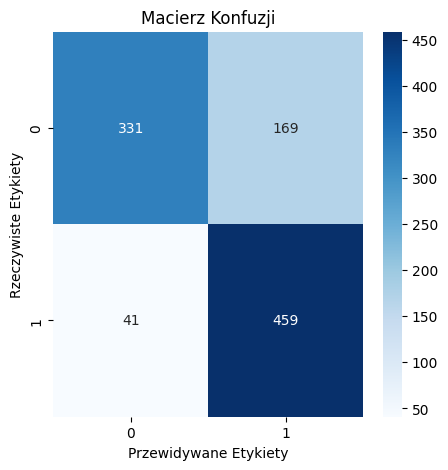

In [17]:
# Macierz konfuzji
conf_matrix = confusion_matrix(true_labels, predicted_labels)
labels = np.unique(true_labels)
confusion_df = pd.DataFrame(conf_matrix, index=labels, columns=labels)

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=labels, yticklabels=labels)
plt.title('Macierz Konfuzji')
plt.xlabel('Przewidywane Etykiety')
plt.ylabel('Rzeczywiste Etykiety')
plt.show()


## Wizualizacja przestrzeni wektorowej - teksty

In [18]:
def embed_text(examples):
    tokens = tokenizer(examples, padding="max_length", truncation=True)
    return tokens

def wrap_text(text, width=40):
    return '<br>'.join([text[i:i+width] for i in range(0, len(text), width)])


In [19]:
text = pd.DataFrame(tokenized_ds['test']['text'], columns=['text'])
text['text'] = text['text'].apply(wrap_text)

embeddings = embed_text(dataset['test']['text'])

PCA

In [34]:
pca = PCA(n_components=2).fit_transform(embeddings['input_ids'])

df_pca = pd.DataFrame(pca, columns=['PCA1', 'PCA2'])
df_pca['Predicted Label']  = [predicted_labels[i] for i in range(len(predicted_labels))]
df_pca['Text'] = text['text']
df_pca['True label'] = [true_labels[i] for i in range(len(true_labels))]

fig = px.scatter(df_pca, x="PCA1", y="PCA2", color="Predicted Label", hover_data={'Text': True, 'True label': True}, title="Wizualizacja przestrzeni wektorowej prób testowych",
                labels={"PC1": "Pierwsza składowa główna", "PC2": "Druga składowa główna"})
fig.write_html("pca_gpt2_texts.html")


In [35]:
import webbrowser

# Path to the HTML file
file_path = "pca_gpt2_texts.html"

# Open the file in the default web browser
webbrowser.open(f"file://{os.path.abspath(file_path)}")


True

TSNE

In [36]:
scaler = StandardScaler()
scaled_vectors = scaler.fit_transform(embeddings['input_ids'])

tsne = TSNE(n_components=2, random_state=42).fit_transform(scaled_vectors)

df_tsne = pd.DataFrame(tsne, columns=['x', 'y'])
df_tsne['Predicted Label']  = [predicted_labels[i] for i in range(len(predicted_labels))]
df_tsne['Text'] = text['text']
df_tsne['True label'] = [true_labels[i] for i in range(len(true_labels))]

fig = px.scatter(df_tsne, x='x', y='y', color='Predicted Label', hover_data={'Text': True, 'True label': True}, title="Wizualizacja przestrzeni wektorowej prób testowych")
fig.write_html("tsne_gpt2_texts.html")


In [ ]:
import webbrowser

# Path to the HTML file
file_path = "tsne_gpt2_texts.html"

# Open the file in the default web browser
webbrowser.open(f"file://{os.path.abspath(file_path)}")


True

: 